
## Limpieza y preprocesado de datos

![](https://datos.gob.es/sites/default/files/u322/grafico.jpg)

## Conjunto de datos para analizar.
Se tiene información de Lending Club, empresa estadounidense de préstamos con sede en San Francisco, California. En dicha compañía, los prestatarios pueden acceder fácilmente a préstamos con tasas de interés bajas.
El dataset contiene datos de todos los préstamos emitidos durante el periodo 2007-2015, con el estado actual del préstamo (actual, cancelado, completamente pagado) y la información de pago más reciente.

Las características adicionales incluyen puntajes de crédito, número de consultas financieras y cobros, entre otros.

Puedes descargar la información al hacer clic en el siguiente enlace:https://drive.google.com/file/d/1oxjXn7PkuqeSdQz5dOMXZOJfhJoBlX3T/view?usp=sharing

¡Comencemos!

In [1]:
#Importa las librerías que vayas a usar para tu proyecto, no olvides importar pandas.

In [1]:
import eda
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from  functools import reduce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",200)

In [2]:
#El primer paso es descargar el archivo, guardarlo en drive y finalmente leerlo con pd.read_csv.

In [3]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/My Drive/Colab Notebooks/UDD/Modulo 02/"
    !ls /content/drive/My\ Drive/Colab\ Notebooks/UDD/Modulo\ 02/
else:
    path = ''

In [4]:
df = pd.read_csv(path + 'dataset_Proyecto_M2.csv')

## Funciones

### Info plus

In [5]:
def infoplus(df, info='default'):
    
    registro = []
    colmax80 = []
    colmin80 = []
    for col in list(df.columns):
        var = []
        var.append(col)
        var.append(str(df[col].dtypes))
        var.append(df[col].count())
        var.append(df.shape[0]-df[col].count())
        var.append(round((1 - ((df.shape[0]-df[col].count()) / df.shape[0])) * 100,4))
        var.append(len(df[col].unique()))
        registro.append(var)
    dftotal = pd.DataFrame(registro, columns=['columna','tipo','total','faltantes','pct','unico'])
    dftotal = dftotal.sort_values(by = 'pct', ascending = False)
         
    if info == 'default':
        return dftotal 
    else:
        print(f'***** El porcentaje de completitud del set de datos es: \033[1m{(df.count().sum()/df.size)*100:.1f}\033[0m%')
        return dftotal 

### Outliers

In [6]:
# Función outliers
def outlierIQR(df,cols):
    results=pd.DataFrame()
    data_iqr=df.copy()
    data_per=df.copy()
    total=[]
    total_per=[]
    total_z=[]
    indices_=[]
    k=1.5

    for col in cols:
        #IQR
        Q1=df[col].quantile(0.25)
        Q3=df[col].quantile(0.75)
        IQR=Q3-Q1
        INF=Q1-k*(IQR)
        SUP=Q3+k*(IQR)


        n_outliers=df[(df[col] < INF) | (df[col] > SUP)].shape[0]
        total.append(n_outliers)
        indices_iqr=list(df[(df[col] < INF) | (df[col] > SUP)].index)
        #data_iqr=data_iqr[~(data_iqr[col] < INF) | (data_iqr[col] > SUP)].reset_index(drop=True)

        #Percentiles
        INF_pe=np.percentile(df[col].dropna(),5)

        SUP_pe=np.percentile(df[col].dropna(),95)
        n_outliers_per=df[(df[col] < INF_pe) | (df[col] > SUP_pe)].shape[0]
        total_per.append(n_outliers_per)
        indices_per=list(df[(df[col] < INF_pe) | (df[col] > SUP_pe)].index)
        #data_per=data_per[~(data_per[col] < INF_pe) | (data_per[col] > SUP_pe)].reset_index(drop=True)

        #MEAN CHANGE

        #Obtenemos todos los percentiles además del máximo
        perc_100 = [x / 100 for x in range(100)]
        dist = df[col].describe(perc_100).iloc[4:]
        #print(dist)
        #Obtenemos el cambio entre percentiles
        change_dist = df[col].describe(perc_100).iloc[4:].diff()
        #print(change_dist)
        #Obtenemos el cambio promedio entre percentiles
        mean_change = df[col].describe(
            perc_100).iloc[4:].diff().mean()
        #Si el cambio entre el percentil 99 y el máximo es mayor a el cambio promedio entonces:
        if change_dist["max"] > mean_change:
            #La banda superior será el máximo menos el cambio promedio
            ub = dist["max"] - mean_change
            #si la banda superior es más pequeña que el percentil 99 , modificamos la banda para que tome el percentil 99
            if ub < dist["99%"]:
                ub = dist["99%"]
        else:
        #9Si el cambio entre el percentil 9 y el máximo es menor o igual a el cambio promedio entonces se toma el percentil 99
            ub = dist["max"]

        if change_dist["1%"] > mean_change:
            lb = dist["0%"] + mean_change
            if lb > dist["1%"]:
                lb = dist["1%"]
        else:
            lb = dist["0%"]
        n_total_z=df[(df[col] < lb) | (df[col] > ub)].shape[0]
        total_z.append(n_total_z)
        indices_z=list(df[(df[col] < lb) | (df[col] > ub)].index)

        indices_.append(aux_outliers(indices_iqr,indices_per,indices_z))

    results["features"]=cols
    results["n_outliers_IQR"]=total
    results["n_outliers_Percentil"]=total_per
    results["n_outliers_Mean_Change"]=total_z
    results["n_outliers_IQR_%"]=round((results["n_outliers_IQR"]/df.shape[0])*100,2)
    results["n_outliers_Percentil_%"]=round((results["n_outliers_Percentil"]/df.shape[0])*100,2)
    results["n_outliers_Mean_Change_%"]=round((results["n_outliers_Mean_Change"]/df.shape[0])*100,2)
    results["indices"]=indices_
    results["total_outliers"]=results["indices"].map(lambda x:len(x))
    results["%_outliers"]=results["indices"].map(lambda x:round(((len(x)/df.shape[0])*100),2))
    results=results[['features', 'n_outliers_IQR', 'n_outliers_Percentil',
       'n_outliers_Mean_Change', 'n_outliers_IQR_%', 'n_outliers_Percentil_%',
       'n_outliers_Mean_Change_%',  'total_outliers', '%_outliers','indices']]
    return results

def aux_outliers(a,b,c):
    a=set(a)
    b=set(b)
    c=set(c)

    a_=a.intersection(b)

    b_=b.intersection(c)

    c_=a.intersection(c)

    outliers_index=list(set(list(a_)+list(b_)+list(c_)))
    return outliers_index

In [7]:
def eliminarOUTLIERS(cols):
    
    reg1 = df.shape[0]
    print(f'Total registros antes de eliminar Outliers: {reg1}')
        
    #dfensamble = pd.melt(df[cols])
    #fig, ax = plt.subplots(figsize = (27, 9))
    #sns.boxplot(x='variable', y='value', data=dfensamble).set(title='Columnas antes de eliminar Ouliers')
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
        
        
    indices=list(outliers["indices"].values)
    print(indices)
    indices=list(set(reduce(lambda x,y: x+y, indices)))
    #print(indices)
    dfdrop = df[~df.index.isin(indices)].reset_index(drop=True)
        
    reg2 = dfdrop.shape[0]
    print(f'Total registros despues de eliminar Outliers: {reg2}\n')  
        
    #dfensamble = pd.melt(dfdrop[cols])
    #fig, ax = plt.subplots(figsize = (27, 9))
    #sns.boxplot(x='variable', y='value', data=dfensamble).set(title='Columnas despues de eliminar Ouliers')
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
        
    print('')
        
    #etiquetas = 'Reg. sin Outliers', 'Reg. con Outliers'
    #datos = [reg2,reg1]
    #titulo = 'Relacion Outliers eliminados'
    #fig, ax = plt.subplots()
    #ax.pie(datos, labels=etiquetas, autopct='%1.1f%%')
    #plt.title(titulo)
    #plt.show() 
    
    return dfdrop

### Imputar

In [8]:
def fnImputar(columnas, estrategia):
    imp = SimpleImputer(missing_values=np.nan, strategy=estrategia)
    imp.fit(df[columnas])
    df[columnas]=imp.transform(df[columnas])
    print(f'***** Imputacion finalizada, {len(columnas)} columnas, criterio usado: {estrategia}')

### Renombrar columnas

In [9]:
def rename_cols(df,cols,prefix):
    new_feats=[prefix+col for col in cols]
    df=df.rename(columns=dict(zip(cols,new_feats)))
    return df

## Parte 1
Dado el _dataset_:

* Identifica el tipo de datos de cada variable y verifica la completitud.
* Determina las variables que son continuas, discretas y la variable objetivo.

> Puedes contar los valores dentro de una variable y utilizar las funciones que desees para cumplir estos objetivos; mientras más completo sea el EDA, mejor puntaje obtendrás.



> Recomendaciones: usa funciones como `.info`, `.head` y `.duplicated`.



In [10]:
dataset = []

In [11]:
df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.shape

(887379, 74)

In [13]:
dataset.append(list(df.shape))

In [14]:
print(f'***** Se puede observar que mediante la funcion Shape, el data set contiene \033[1m{df.shape[0]}\033[0m registros y \033[1m{df.shape[1]}\033[0m columnas')

***** Se puede observar que mediante la funcion Shape, el data set contiene 887379 registros y 74 columnas


In [15]:
#print(f'***** El listado de las \033[1m{df.shape[1]}\033[0m columnas son las siguientes:')
#list(df.columns)

In [16]:
print('***** Para identificar los tipos de datos para cada variable, use la funcion info()\n')
df.info()

***** Para identificar los tipos de datos para cada variable, use la funcion info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842

### Completitud

<div class="alert alert-block alert-info">
    
> Para calcular la completitud de los datos use la funcion infoplus.
> Esta funcion entrega un dataframe con los valores de completitud con las siguientes columnas:
> - columna: el nombre de la columna
> - tipo: el tipo de datos de la correspondiente columna
> - total: el total de registros para la columna
> - faltantes: los registros faltantes 
> - pct: porcentaje de completitud en el conjunto de datos
> - unico: total de posibles categorias existentes
</div>

In [17]:
if df.isnull().values.any():
    print('***** Los datos NO estan completos')
else:
    print('***** Los datos estan completos')

***** Los datos NO estan completos


In [19]:
eda.infoplus(df)

El porcentaje de completitud es de: 72.6%



,columna,tipo,total,faltantes,pct,unico
0,id,int64,887379,0,100.0000,887379
39,total_pymnt_inv,float64,887379,0,100.0000,506616
23,addr_state,object,887379,0,100.0000,51
24,dti,float64,887379,0,100.0000,4086
32,revol_bal,float64,887379,0,100.0000,73740
...,...,...,...,...,...,...
63,mths_since_rcnt_il,float64,20810,866569,2.3451,202
65,il_util,float64,18617,868762,2.0980,1273
53,annual_inc_joint,float64,511,886868,0.0576,309
55,verification_status_joint,object,511,886868,0.0576,4


In [18]:
completitud = infoplus(df,'completitud')

***** El porcentaje de completitud del set de datos es: 72.6%


#### Variables con completitud mayor o igual a 80%

In [20]:
max80 = completitud[completitud['pct']>=80]
colmax80 = list(max80['columna'].values)

In [21]:
print(f'***** El Dataframe resultante de la completitud contiene \033[1m{max80.shape[0]}\033[0m columnas')

***** El Dataframe resultante de la completitud contiene 52 columnas


In [22]:
max80

,columna,tipo,total,faltantes,pct,unico
0,id,int64,887379,0,100.0000,887379
39,total_pymnt_inv,float64,887379,0,100.0000,506616
23,addr_state,object,887379,0,100.0000,51
24,dti,float64,887379,0,100.0000,4086
32,revol_bal,float64,887379,0,100.0000,73740
35,initial_list_status,object,887379,0,100.0000,2
36,out_prncp,float64,887379,0,100.0000,248332
1,member_id,int64,887379,0,100.0000,887379
38,total_pymnt,float64,887379,0,100.0000,506726
40,total_rec_prncp,float64,887379,0,100.0000,260227


#### Variables con completitud menor a 80%

In [23]:
min80 = completitud[completitud['pct'] < 80]
colmin80 = list(min80['columna'].values)

In [24]:
print(f'***** El Dataframe resultante que es menor a 80% contiene \033[1m{min80.shape[0]}\033[0m columnas')

***** El Dataframe resultante que es menor a 80% contiene 22 columnas


In [25]:
min80

,columna,tipo,total,faltantes,pct,unico
47,next_pymnt_d,object,634408,252971,71.4923,101
28,mths_since_last_delinq,float64,433067,454312,48.8029,156
50,mths_since_last_major_derog,float64,221703,665676,24.9840,169
29,mths_since_last_record,float64,137053,750326,15.4447,124
19,desc,object,126028,761351,14.2023,124470
73,inq_last_12m,float64,21372,866007,2.4084,30
71,inq_fi,float64,21372,866007,2.4084,19
59,open_acc_6m,float64,21372,866007,2.4084,14
60,open_il_6m,float64,21372,866007,2.4084,36
61,open_il_12m,float64,21372,866007,2.4084,13


#### Grafico relacion de completitud

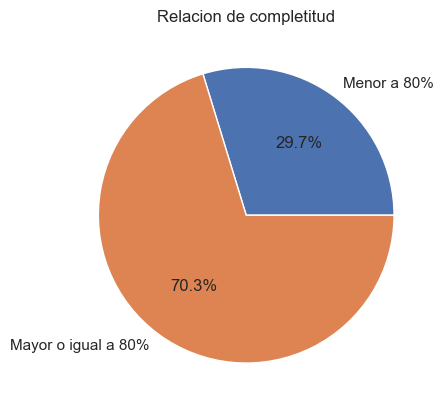

In [26]:
etiquetas = 'Menor a 80%', 'Mayor o igual a 80%'
datos = [min80.shape[0],max80.shape[0]]
titulo = 'Relacion de completitud'

fig, ax = plt.subplots()
ax.pie(datos, labels=etiquetas, autopct='%1.1f%%')
plt.title(titulo)
plt.show()

<div class="alert alert-block alert-info">
Como se puede observar en el grafico, las columnas que no cumplen la completitud menor al 80%, correspondiente al 29.7% del total de los datos, estas no son aptas para el analisis. Entonces se procedera a eliminarlas
</div>

## Parte 2
* Elimina los datos faltantes o duplicados con el método que sea más conveniente y justifica tu elección.

* Elimina las variables cuyo valor de completitud sea menor a 80; después, identifica y modifica aquellos valores atípicos (_outliers_).

In [27]:
# dataframe nuevo
df1 = df.copy()

In [28]:
#df= df1.copy()

### Eliminacion de variables con completitud menor a 80%

In [29]:
print(f'***** Se procede a eliminar las \033[1m{len(colmin80)}\033[0m columnas que estan por debajo del 80% de la Completitud')
df = df.drop(columns=colmin80)

***** Se procede a eliminar las 22 columnas que estan por debajo del 80% de la Completitud


### Eliminacion columnas que no aportan al analisis

In [30]:
max80[max80['unico']==df.shape[0]]

,columna,tipo,total,faltantes,pct,unico
0,id,int64,887379,0,100.0,887379
1,member_id,int64,887379,0,100.0,887379
18,url,object,887379,0,100.0,887379


In [31]:
max80[max80['unico']==1]

,columna,tipo,total,faltantes,pct,unico
51,policy_code,float64,887379,0,100.0,1


<div class="alert alert-block alert-info">
    
> - Se puede observar que los campos id y member_id, tanto el total de registros como su valor unico son iguales, lo que indica que son de tipo identity, es decir, un valor entero autonumerico.
> - Lo mismo para el campo url, el valor unico tiene el mismo tamaño que que el total de registros y ademas es de tipo categorico
> - Otra variante es cuando el valor unico es 1, que indica que solo existe un unico valor repetido n veces, que tampoco agrega valor al estudio
</div>

In [32]:
noanalisis = ['id','member_id', 'url', 'policy_code']

In [33]:
df = df.drop(noanalisis,axis=1)

### Analisis de Duplicados

In [34]:
dup = df[df.duplicated()]
if dup.shape[0] == 0:
    print('No existen duplicados en el set de datos')
else:
    print(f'Existen {dup.shape[0]} duplicados en el set de datos')

No existen duplicados en el set de datos


In [35]:
df.shape

(887379, 48)

In [36]:
dataset.append(list(df.shape))

In [37]:
print(f'***** Se puede observar que mediante la funcion Shape, el data set contiene \033[1m{df.shape[0]}\033[0m registros y \033[1m{df.shape[1]}\033[0m columnas.')

***** Se puede observar que mediante la funcion Shape, el data set contiene 887379 registros y 48 columnas.


### Tipos de datos

In [38]:
completitud = infoplus(df) 
completitud.tail()

,columna,tipo,total,faltantes,pct,unico
9,emp_length,object,842554,44825,94.9486,12
8,emp_title,object,835917,51462,94.2007,299272
45,tot_coll_amt,float64,817103,70276,92.0805,10326
46,tot_cur_bal,float64,817103,70276,92.0805,327343
47,total_rev_hi_lim,float64,817103,70276,92.0805,21252


In [39]:
tiponum = completitud[completitud['tipo'] == 'float64']
colnum = list(tiponum['columna'].values)

In [40]:
tipoobj = completitud[completitud['tipo'] == 'object']
colobj = list(tipoobj['columna'].values)

In [41]:
outliers = outlierIQR(df,colnum)

In [42]:
outcol = list(outliers['features'][outliers['total_outliers'] > 0])

In [43]:
print(f'***** Hay {len(outcol)} columnas que contienen valores anomalos')

***** Hay 29 columnas que contienen valores anomalos


### Imputar

<div class="alert alert-block alert-info">
Se procede a imputar variables que contienen outliers, para la imputacion se usara la <b>mediana</b>, ya que es un valor de tendencia central que no se ve afectado por los valores anomalos.
    Ademas se imputaran las variables categoricas, usando la <b>moda o el mas frecuente</b>
</div>

In [44]:
fnImputar(outcol,'median') #median

***** Imputacion finalizada, 29 columnas, criterio usado: median


In [45]:
fnImputar(colobj,'most_frequent')

***** Imputacion finalizada, 19 columnas, criterio usado: most_frequent


In [46]:
completitud = infoplus(df,'completitud')

***** El porcentaje de completitud del set de datos es: 100.0%


In [47]:
if df.isnull().values.any():
    print('***** Los datos NO estan completos')
else:
    print('***** Los datos estan completos')

***** Los datos estan completos


### Outliers

#### Individualizacion

In [48]:
outliers = outlierIQR(df,colnum)

In [49]:
outliers.head(3)

,features,n_outliers_IQR,n_outliers_Percentil,n_outliers_Mean_Change,n_outliers_IQR_%,n_outliers_Percentil_%,n_outliers_Mean_Change_%,total_outliers,%_outliers,indices
0,loan_amnt,0,86204,26,0.00,9.71,0.0,26,0.00,"[39442, 38932, 38936, 42136, 39331, 39466, 422..."
1,total_pymnt,46324,88737,1,5.22,10.00,0.0,44368,5.00,"[786437, 131084, 393231, 20, 131093, 393241, 1..."
2,out_prncp,3363,44354,1,0.38,5.00,0.0,3363,0.38,"[499714, 466949, 540678, 483338, 507917, 46695..."


In [50]:
outcol = list(outliers['features'][outliers['total_outliers'] > 0])

In [51]:
dfo = eliminarOUTLIERS(outcol)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Total registros despues de eliminar Outliers: 560995




In [52]:
dfo.shape

(560995, 48)

In [53]:
dataset.append(list(dfo.shape))

In [54]:
df = dfo.copy()

In [55]:
info = infoplus(df)

### Histogramas

In [56]:
dfnum = df.select_dtypes(include = ['float64', 'int64'])

array([[<AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt_inv'}>,
        <AxesSubplot:title={'center':'int_rate'}>,
        <AxesSubplot:title={'center':'installment'}>],
       [<AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>,
        <AxesSubplot:title={'center':'open_acc'}>],
       [<AxesSubplot:title={'center':'pub_rec'}>,
        <AxesSubplot:title={'center':'revol_bal'}>,
        <AxesSubplot:title={'center':'revol_util'}>,
        <AxesSubplot:title={'center':'total_acc'}>,
        <AxesSubplot:title={'center':'out_prncp'}>],
       [<AxesSubplot:title={'center':'out_prncp_inv'}>,
        <AxesSubplot:title={'center':'total_pymnt'}>,
        <AxesSubplot:title={'center':'total_pymnt_inv'}>,
        <AxesSubplot:title={'center':'to

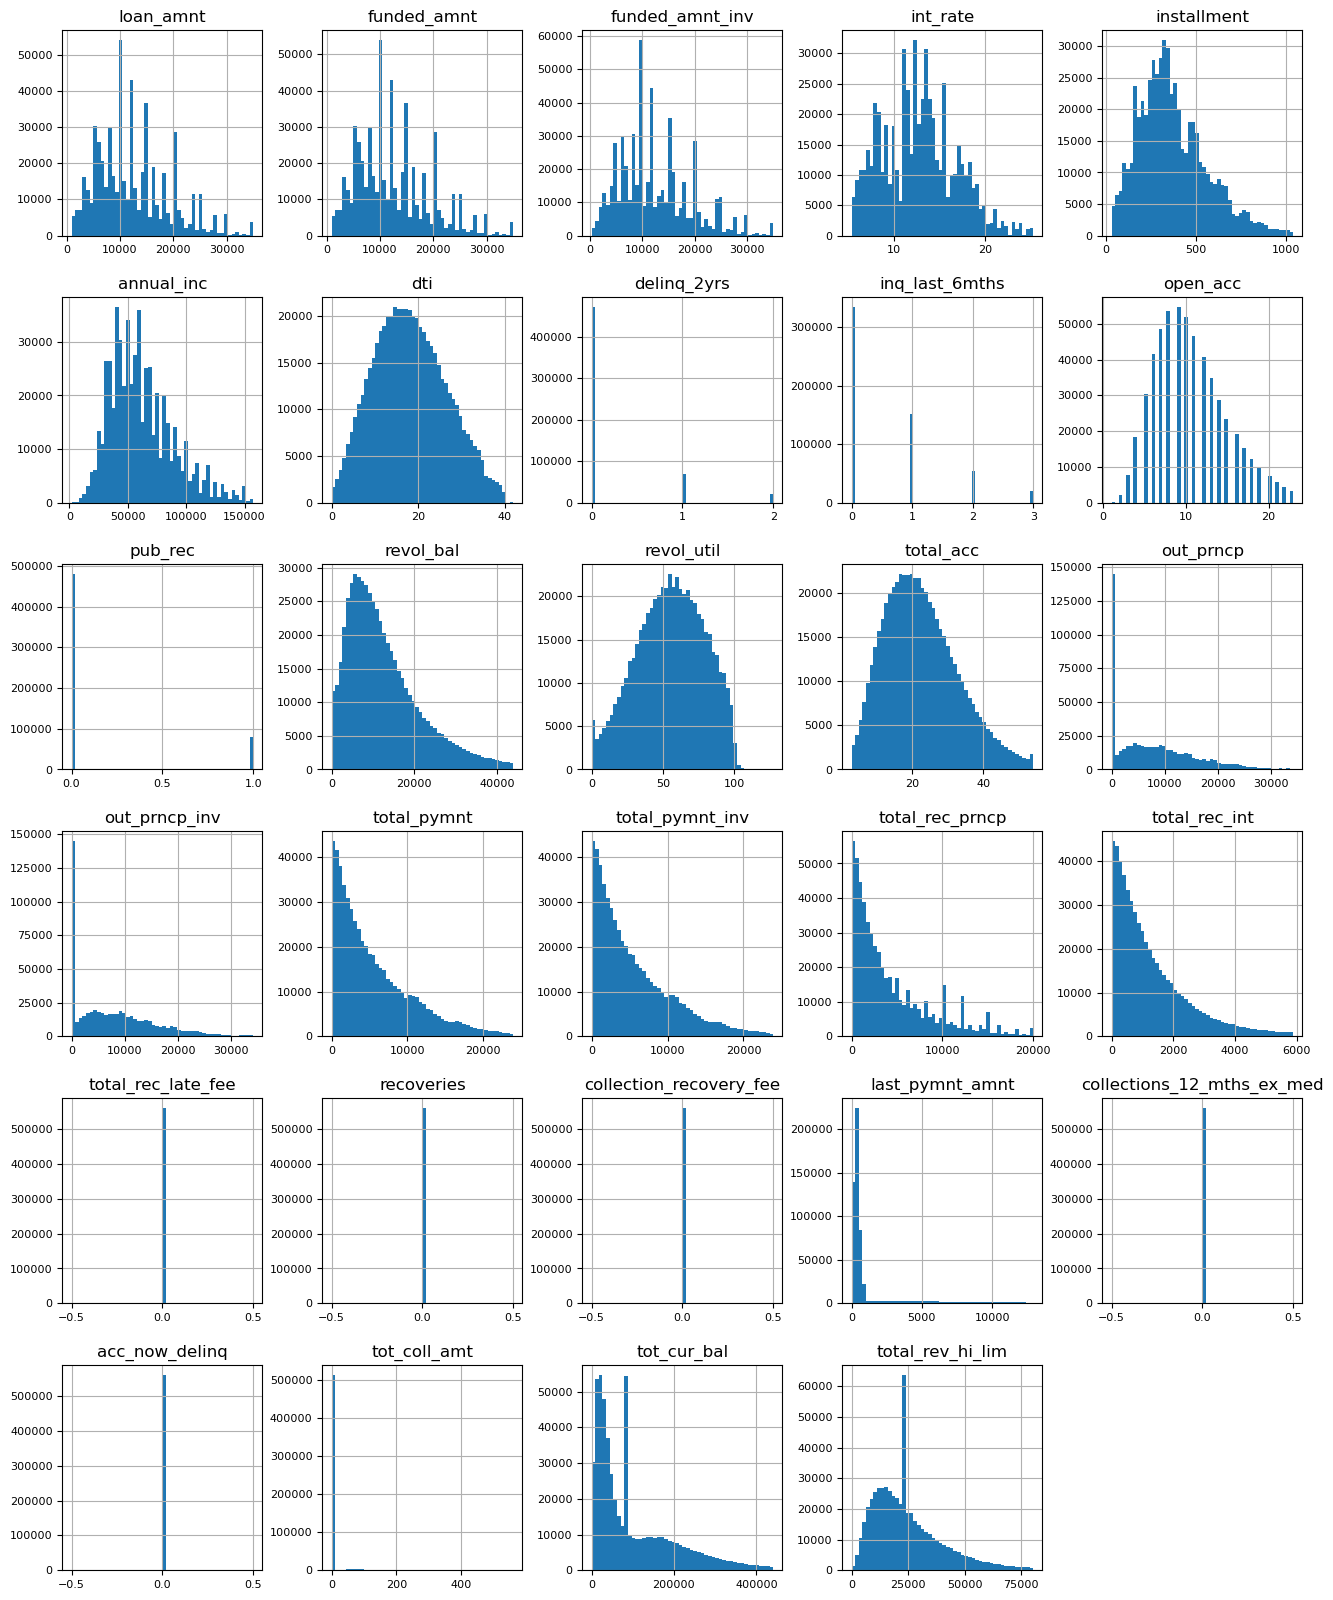

In [57]:
dfnum.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8)

### Eliminacion columnas con datos unicos

In [58]:
colunico = info[info['unico']==1]
colunico = list(colunico['columna'].values)
colunico

['total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'acc_now_delinq']

In [59]:
df = df.drop(colunico,axis=1)

In [60]:
df.shape

(560995, 43)

In [61]:
dataset.append(list(df.shape))

### Estado dataset

In [62]:
nombres = ['original','borrado','outliers','unicos']
columnas = ['registros','columnas','EDA']
dfds = pd.DataFrame(dataset)
dfds[2] = nombres
dfds.columns = columnas
dfds

,registros,columnas,EDA
0,887379,74,original
1,887379,48,borrado
2,560995,48,outliers
3,560995,43,unicos


### Histogramas

In [63]:
dfnum = df.select_dtypes(include = ['float64', 'int64'])

array([[<AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt_inv'}>,
        <AxesSubplot:title={'center':'int_rate'}>,
        <AxesSubplot:title={'center':'installment'}>],
       [<AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>,
        <AxesSubplot:title={'center':'open_acc'}>],
       [<AxesSubplot:title={'center':'pub_rec'}>,
        <AxesSubplot:title={'center':'revol_bal'}>,
        <AxesSubplot:title={'center':'revol_util'}>,
        <AxesSubplot:title={'center':'total_acc'}>,
        <AxesSubplot:title={'center':'out_prncp'}>],
       [<AxesSubplot:title={'center':'out_prncp_inv'}>,
        <AxesSubplot:title={'center':'total_pymnt'}>,
        <AxesSubplot:title={'center':'total_pymnt_inv'}>,
        <AxesSubplot:title={'center':'to

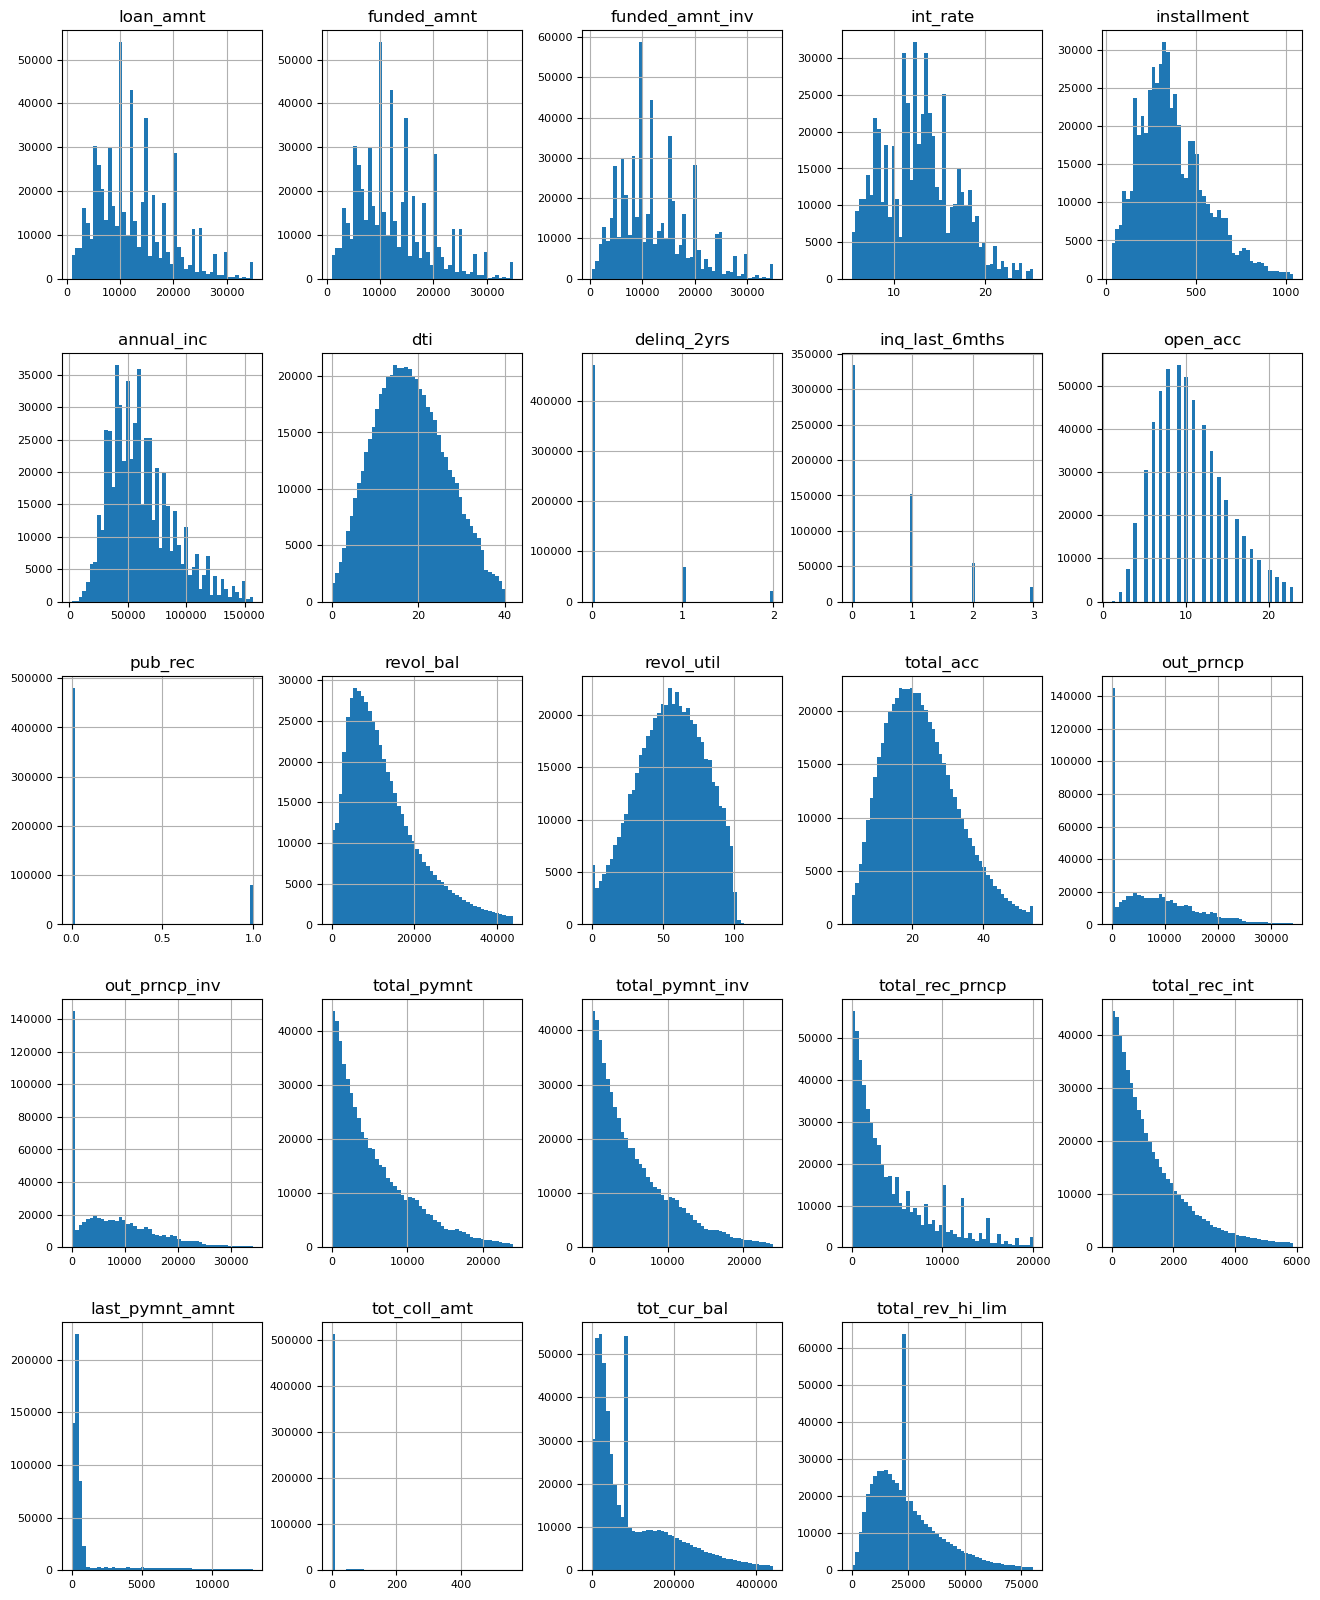

In [64]:
dfnum.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8)

### Correlacion entre variables y mapa de calor

In [65]:
cor = df.corr().round(2)

<AxesSubplot:>

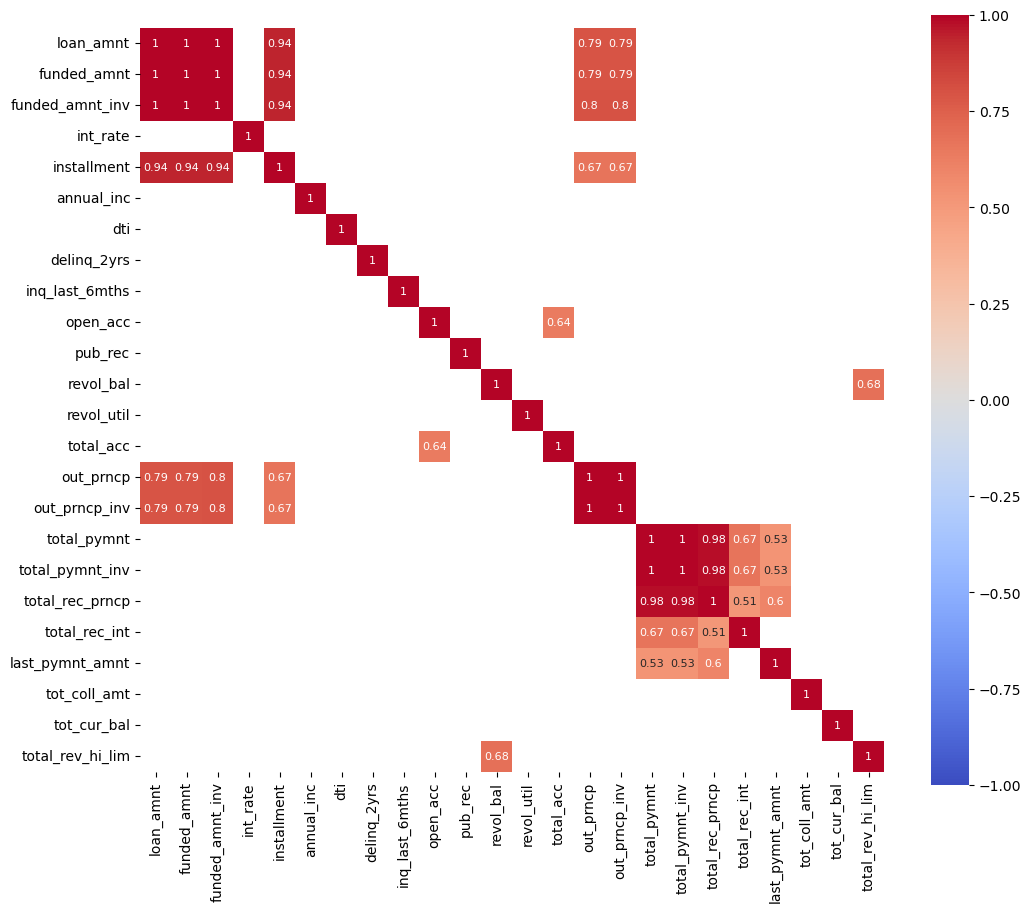

In [66]:
f, ax = plt.subplots(figsize=(12, 10))
#corr = df.corr()
sns.heatmap(cor[(cor>=0.5) | (cor<=-0.5)],
            cmap='coolwarm',
            vmax=1,
            vmin=-1,
            annot=True,
            annot_kws={'size':8}, 
            square=True,
            xticklabels=cor.columns.values,
            yticklabels=cor.columns.values)

<div class="alert alert-block alert-info">
    Se puede observar que hay <b>2 focos</b> que concentran una gran correlacion:
    
> - <b>total_pymnt</b>, sin embargo para este grupo, la distribucion no es normal, sino mas bien exponencial.
> - <b>loan_amnt</b>, en cambio, para este grupo, la distribucion es normal, por lo que se usara como variable objetivo. Ademas tiene mas sentido si estamos tratando datos en relacion a prestamos (loan)
</div>

### Correlacion con la variable target loan_amnt

In [67]:
cor_target = abs(cor['loan_amnt'])
relevant_features = cor_target[cor_target>0.5]
relevant_features

loan_amnt          1.00
funded_amnt        1.00
funded_amnt_inv    1.00
installment        0.94
out_prncp          0.79
out_prncp_inv      0.79
Name: loan_amnt, dtype: float64

In [68]:
tiponum = info[info['tipo'] == 'float64']
colnum = list(tiponum['columna'].values)

In [69]:
tipoobj = info[info['tipo'] == 'object']
colobj = list(tipoobj['columna'].values)

### Cambio nombre de variables

In [70]:
tgt=['loan_amnt']

df=rename_cols(df,tgt,"tgt_")
df=rename_cols(df,colobj,"v_")
df=rename_cols(df,colnum,"c_")


In [71]:
df.head(3)

,tgt_loan_amnt,c_funded_amnt,c_funded_amnt_inv,v_term,c_int_rate,c_installment,v_grade,v_sub_grade,v_emp_title,v_emp_length,v_home_ownership,c_annual_inc,v_verification_status,v_issue_d,v_loan_status,v_pymnt_plan,v_purpose,v_title,v_zip_code,v_addr_state,c_dti,c_delinq_2yrs,v_earliest_cr_line,c_inq_last_6mths,c_open_acc,c_pub_rec,c_revol_bal,c_revol_util,c_total_acc,v_initial_list_status,c_out_prncp,c_out_prncp_inv,c_total_pymnt,c_total_pymnt_inv,c_total_rec_prncp,c_total_rec_int,v_last_pymnt_d,c_last_pymnt_amnt,v_last_credit_pull_d,v_application_type,c_tot_coll_amt,c_tot_cur_bal,c_total_rev_hi_lim
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,Teacher,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.0,861.07,Jan-2015,171.62,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0
1,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,Teacher,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.0,603.65,Jun-2014,649.91,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0
2,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.1,1009.07,Jan-2016,67.79,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0


### Identificacion variables correlacionadas con la variable objetivo

In [72]:
colcor = ['tgt_loan_amnt','c_funded_amnt','c_funded_amnt_inv','c_installment','c_out_prncp','c_out_prncp_inv']

## Parte 3
Usa un transformador o los transformadores necesarios y justifica tu elección.

In [73]:
df2 = df.copy()

In [74]:
#df= df2.copy()

In [75]:
dfcor = df[colcor].copy()

<div class="alert alert-block alert-info">
Los datos se escalaran usando StandarScaler
    $$
Z_i=\frac{X_i - \mu}{\sigma}
$$
Donde:
    
> - $Z_i$ es el nuevo valor estándar por cada valor (fila).
> - $X_i$ es el valor original de $X$ por cada valor (fila).
> - $\mu$ es el promedio de $X$.
> - $\sigma$ es la variación estándar de $X$.
    
Lo que logramos con esta estandarizacion es llevar la <b>media a cero y la desviacion standar a 1</b>.
Y asi poder comparar los datos que estan en bruto.
</div>

### Estandarizacion variables numericas

In [76]:
escalador = StandardScaler()
dfcor[colcor] = escalador.fit_transform(dfcor[colcor])

In [77]:
dfcor.head()

,tgt_loan_amnt,c_funded_amnt,c_funded_amnt_inv,c_installment,c_out_prncp,c_out_prncp_inv
0,-1.099540,-1.098713,-1.097285,-1.106943,-1.050671,-1.050676
1,-1.481571,-1.480936,-1.475370,-1.524085,-1.050671,-1.050676
2,-1.393410,-1.392731,-1.387273,-1.611933,-0.948005,-0.947968
3,-1.099540,-1.098713,-1.093615,-1.140988,-1.050671,-1.050676
4,-0.805670,-0.804696,-0.799956,-1.068650,-0.797767,-0.797669


### Histogramas

In [78]:
dfnum = df.select_dtypes(include = ['float64', 'int64'])

array([[<AxesSubplot:title={'center':'tgt_loan_amnt'}>,
        <AxesSubplot:title={'center':'c_funded_amnt'}>],
       [<AxesSubplot:title={'center':'c_funded_amnt_inv'}>,
        <AxesSubplot:title={'center':'c_installment'}>],
       [<AxesSubplot:title={'center':'c_out_prncp'}>,
        <AxesSubplot:title={'center':'c_out_prncp_inv'}>]], dtype=object)

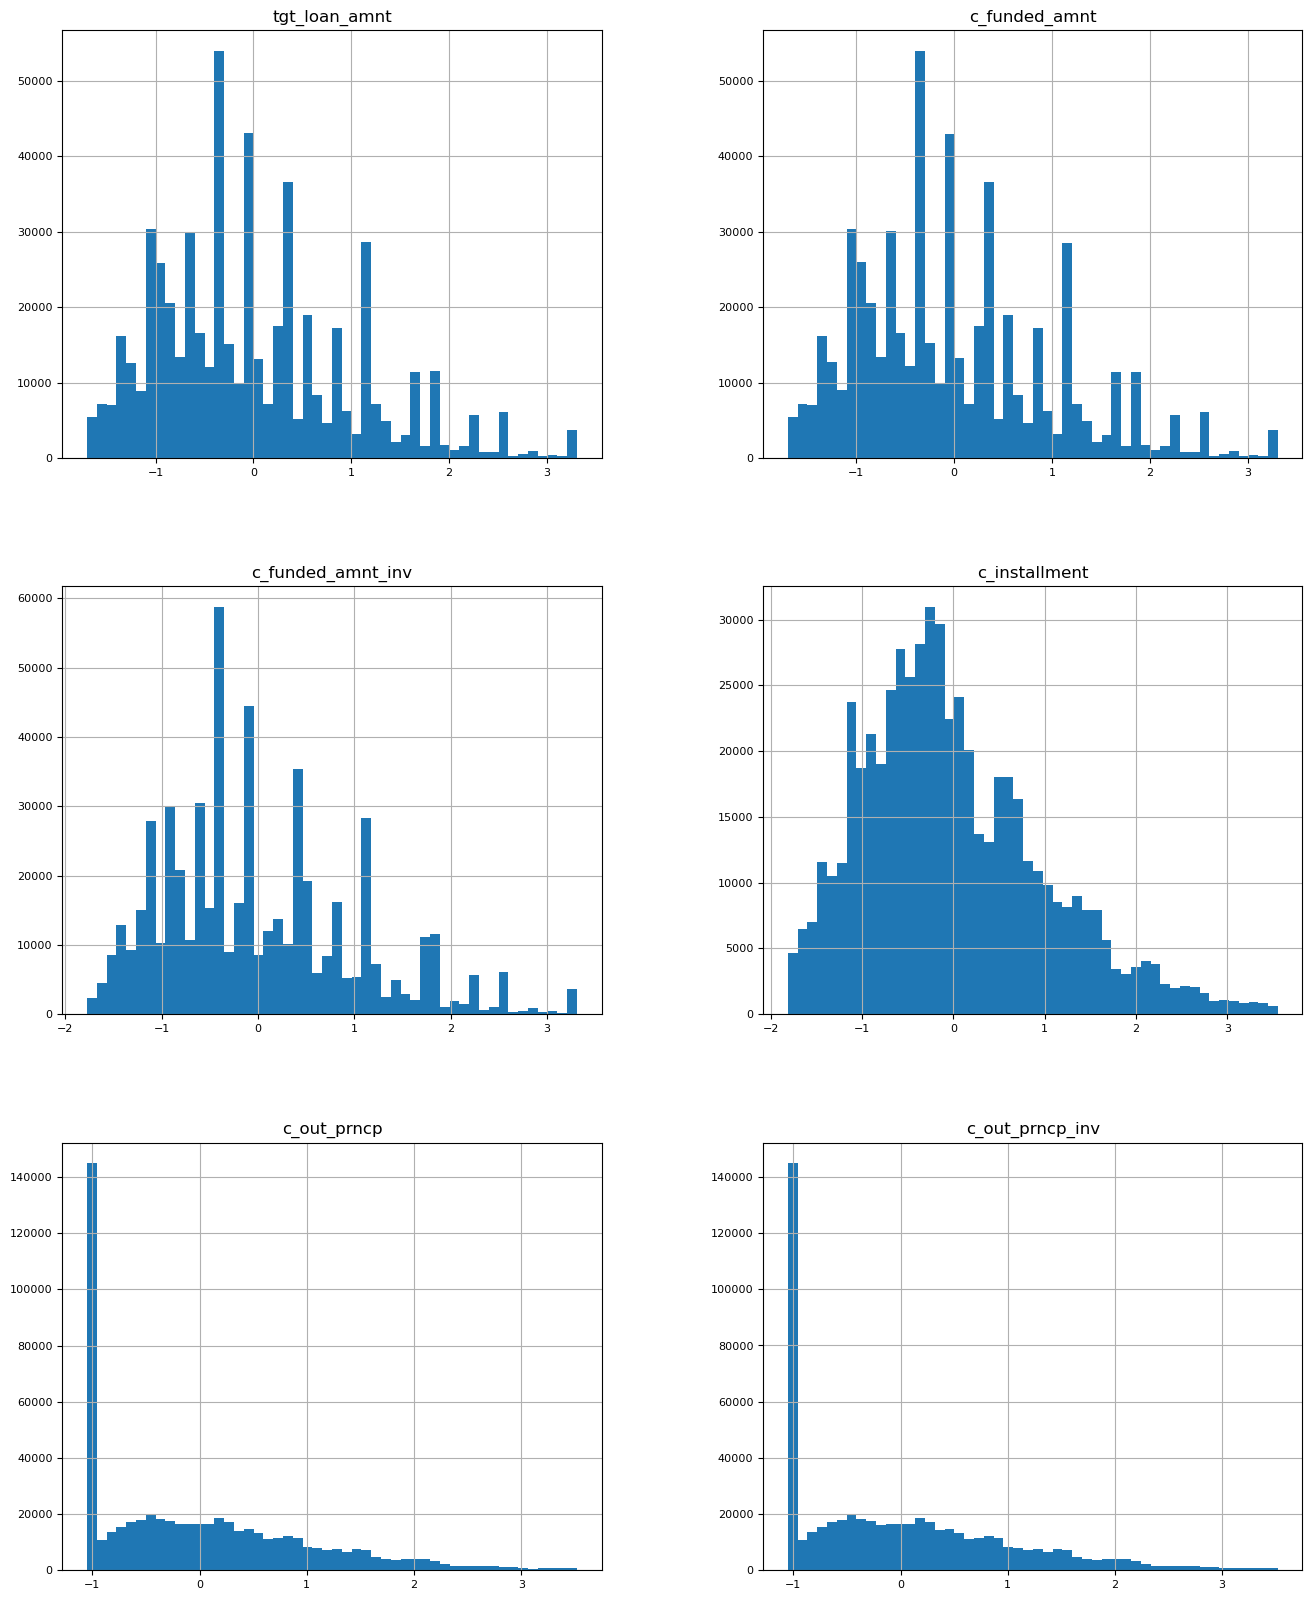

In [79]:
dfcor.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8)

### Correlacion 

In [80]:
corss = dfcor.corr().round(2)

<AxesSubplot:>

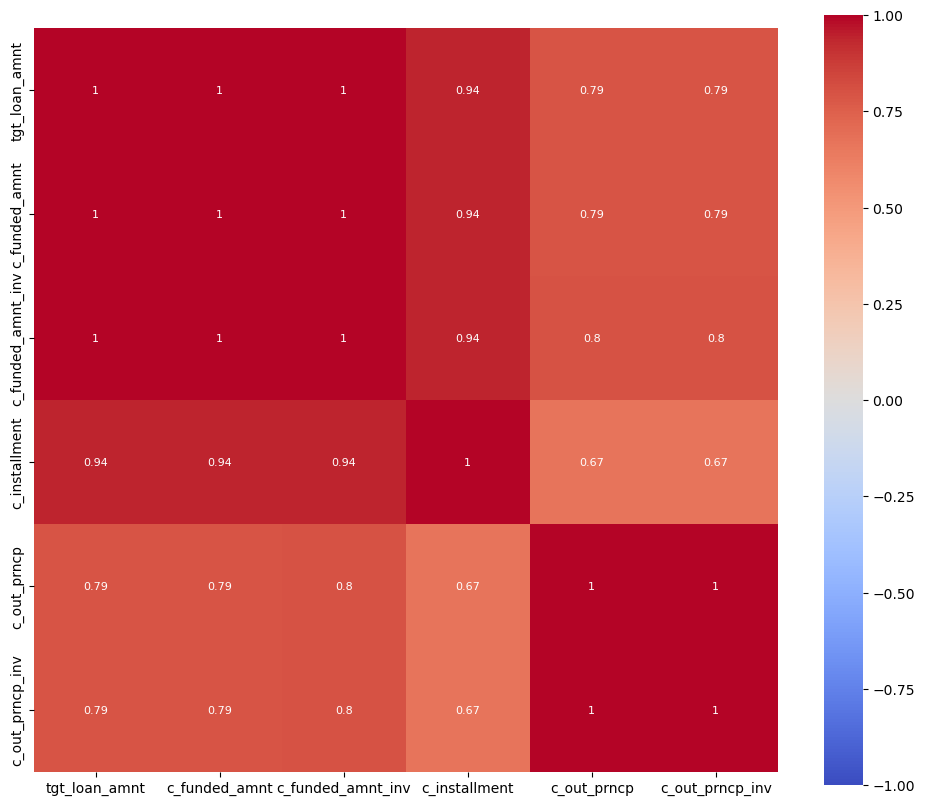

In [81]:
f, ax = plt.subplots(figsize=(12, 10))
#corr = df.corr()
sns.heatmap(corss[(corss>=0.5) | (corss<=-0.5)],
            cmap='coolwarm',
            vmax=1,
            vmin=-1,
            annot=True,
            annot_kws={'size':8}, 
            square=True,
            xticklabels=dfcor.columns.values,
            yticklabels=dfcor.columns.values)

### Estandarizacion variables texto

<div class="alert alert-block alert-info">
Como parte del ejercicio se estandarizara los datos categoricos usando 3 metodos distintos
    
> - dummies
> - label encoder
> - one hot encoder
</div>

In [82]:
df= df2.copy()

In [83]:
df.head()

,tgt_loan_amnt,c_funded_amnt,c_funded_amnt_inv,v_term,c_int_rate,c_installment,v_grade,v_sub_grade,v_emp_title,v_emp_length,v_home_ownership,c_annual_inc,v_verification_status,v_issue_d,v_loan_status,v_pymnt_plan,v_purpose,v_title,v_zip_code,v_addr_state,c_dti,c_delinq_2yrs,v_earliest_cr_line,c_inq_last_6mths,c_open_acc,c_pub_rec,c_revol_bal,c_revol_util,c_total_acc,v_initial_list_status,c_out_prncp,c_out_prncp_inv,c_total_pymnt,c_total_pymnt_inv,c_total_rec_prncp,c_total_rec_int,v_last_pymnt_d,c_last_pymnt_amnt,v_last_credit_pull_d,v_application_type,c_tot_coll_amt,c_tot_cur_bal,c_total_rev_hi_lim
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,Teacher,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.00,0.00,5861.071414,5831.78,5000.00,861.07,Jan-2015,171.62,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0
1,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,Teacher,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.00,0.00,3003.653644,3003.65,2400.00,603.65,Jun-2014,649.91,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0
2,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.90,766.90,3242.170000,3242.17,2233.10,1009.07,Jan-2016,67.79,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0
3,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,Dec-2011,Fully Paid,n,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0.0,Nov-2004,3.0,9.0,0.0,7963.0,28.3,12.0,f,0.00,0.00,5631.377753,5631.38,5000.00,631.38,Jan-2015,161.03,Sep-2015,INDIVIDUAL,0.0,80559.0,23700.0
4,7000.0,7000.0,7000.0,60 months,15.96,170.08,C,C5,Southern Star Photography,8 years,RENT,47004.0,Not Verified,Dec-2011,Current,n,debt_consolidation,Loan,280xx,NC,23.51,0.0,Jul-2005,1.0,7.0,0.0,17726.0,85.6,11.0,f,1889.15,1889.15,8136.840000,8136.84,5110.85,3025.99,Jan-2016,170.08,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0


In [84]:
info = infoplus(df)
info = info[info['tipo']=='object']
info

,columna,tipo,total,faltantes,pct,unico
29,v_initial_list_status,object,560995,0,100.0,2
22,v_earliest_cr_line,object,560995,0,100.0,677
36,v_last_pymnt_d,object,560995,0,100.0,97
38,v_last_credit_pull_d,object,560995,0,100.0,101
39,v_application_type,object,560995,0,100.0,2
10,v_home_ownership,object,560995,0,100.0,6
3,v_term,object,560995,0,100.0,2
6,v_grade,object,560995,0,100.0,7
7,v_sub_grade,object,560995,0,100.0,35
8,v_emp_title,object,560995,0,100.0,202112


In [85]:
df['v_home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

#### Usando dummies

In [86]:
prefijo = 'ownshp'

In [87]:
df = pd.get_dummies(data=df, columns=['v_home_ownership'], prefix=prefijo)
colcat = list(df.filter(like=prefijo).columns)
colcat

['ownshp_ANY',
 'ownshp_MORTGAGE',
 'ownshp_NONE',
 'ownshp_OTHER',
 'ownshp_OWN',
 'ownshp_RENT']

In [88]:
df.head()

,tgt_loan_amnt,c_funded_amnt,c_funded_amnt_inv,v_term,c_int_rate,c_installment,v_grade,v_sub_grade,v_emp_title,v_emp_length,c_annual_inc,v_verification_status,v_issue_d,v_loan_status,v_pymnt_plan,v_purpose,v_title,v_zip_code,v_addr_state,c_dti,c_delinq_2yrs,v_earliest_cr_line,c_inq_last_6mths,c_open_acc,c_pub_rec,c_revol_bal,c_revol_util,c_total_acc,v_initial_list_status,c_out_prncp,c_out_prncp_inv,c_total_pymnt,c_total_pymnt_inv,c_total_rec_prncp,c_total_rec_int,v_last_pymnt_d,c_last_pymnt_amnt,v_last_credit_pull_d,v_application_type,c_tot_coll_amt,c_tot_cur_bal,c_total_rev_hi_lim,ownshp_ANY,ownshp_MORTGAGE,ownshp_NONE,ownshp_OTHER,ownshp_OWN,ownshp_RENT
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,Teacher,10+ years,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.00,0.00,5861.071414,5831.78,5000.00,861.07,Jan-2015,171.62,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0,0,0,0,0,0,1
1,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,Teacher,10+ years,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.00,0.00,3003.653644,3003.65,2400.00,603.65,Jun-2014,649.91,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0,0,0,0,0,0,1
2,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,80000.0,Source Verified,Dec-2011,Current,n,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.90,766.90,3242.170000,3242.17,2233.10,1009.07,Jan-2016,67.79,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0,0,0,0,0,0,1
3,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,36000.0,Source Verified,Dec-2011,Fully Paid,n,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0.0,Nov-2004,3.0,9.0,0.0,7963.0,28.3,12.0,f,0.00,0.00,5631.377753,5631.38,5000.00,631.38,Jan-2015,161.03,Sep-2015,INDIVIDUAL,0.0,80559.0,23700.0,0,0,0,0,0,1
4,7000.0,7000.0,7000.0,60 months,15.96,170.08,C,C5,Southern Star Photography,8 years,47004.0,Not Verified,Dec-2011,Current,n,debt_consolidation,Loan,280xx,NC,23.51,0.0,Jul-2005,1.0,7.0,0.0,17726.0,85.6,11.0,f,1889.15,1889.15,8136.840000,8136.84,5110.85,3025.99,Jan-2016,170.08,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0,0,0,0,0,0,1


#### Usando Label Encoder

In [89]:
df['v_grade'].unique()

array(['B', 'C', 'A', 'E', 'D', 'F', 'G'], dtype=object)

In [90]:
transformador = LabelEncoder()

In [91]:
df['v_grade'] = transformador.fit_transform(df['v_grade'])

In [92]:
df.head()

,tgt_loan_amnt,c_funded_amnt,c_funded_amnt_inv,v_term,c_int_rate,c_installment,v_grade,v_sub_grade,v_emp_title,v_emp_length,c_annual_inc,v_verification_status,v_issue_d,v_loan_status,v_pymnt_plan,v_purpose,v_title,v_zip_code,v_addr_state,c_dti,c_delinq_2yrs,v_earliest_cr_line,c_inq_last_6mths,c_open_acc,c_pub_rec,c_revol_bal,c_revol_util,c_total_acc,v_initial_list_status,c_out_prncp,c_out_prncp_inv,c_total_pymnt,c_total_pymnt_inv,c_total_rec_prncp,c_total_rec_int,v_last_pymnt_d,c_last_pymnt_amnt,v_last_credit_pull_d,v_application_type,c_tot_coll_amt,c_tot_cur_bal,c_total_rev_hi_lim,ownshp_ANY,ownshp_MORTGAGE,ownshp_NONE,ownshp_OTHER,ownshp_OWN,ownshp_RENT
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,1,B2,Teacher,10+ years,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.00,0.00,5861.071414,5831.78,5000.00,861.07,Jan-2015,171.62,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0,0,0,0,0,0,1
1,2400.0,2400.0,2400.0,36 months,15.96,84.33,2,C5,Teacher,10+ years,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.00,0.00,3003.653644,3003.65,2400.00,603.65,Jun-2014,649.91,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0,0,0,0,0,0,1
2,3000.0,3000.0,3000.0,60 months,12.69,67.79,1,B5,University Medical Group,1 year,80000.0,Source Verified,Dec-2011,Current,n,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.90,766.90,3242.170000,3242.17,2233.10,1009.07,Jan-2016,67.79,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0,0,0,0,0,0,1
3,5000.0,5000.0,5000.0,36 months,7.90,156.46,0,A4,Veolia Transportaton,3 years,36000.0,Source Verified,Dec-2011,Fully Paid,n,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0.0,Nov-2004,3.0,9.0,0.0,7963.0,28.3,12.0,f,0.00,0.00,5631.377753,5631.38,5000.00,631.38,Jan-2015,161.03,Sep-2015,INDIVIDUAL,0.0,80559.0,23700.0,0,0,0,0,0,1
4,7000.0,7000.0,7000.0,60 months,15.96,170.08,2,C5,Southern Star Photography,8 years,47004.0,Not Verified,Dec-2011,Current,n,debt_consolidation,Loan,280xx,NC,23.51,0.0,Jul-2005,1.0,7.0,0.0,17726.0,85.6,11.0,f,1889.15,1889.15,8136.840000,8136.84,5110.85,3025.99,Jan-2016,170.08,Jan-2016,INDIVIDUAL,0.0,80559.0,23700.0,0,0,0,0,0,1


#### Usando One Hot Encoder

In [108]:
df['v_term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [109]:
columnas = list(df['v_term'].unique())
columnas

[' 36 months', ' 60 months']

In [94]:
transformador = OneHotEncoder()

In [95]:
enc_df = pd.DataFrame(transformador.fit_transform(df[['v_term']]).toarray(), columns=columnas)

In [96]:
enc_df

,36 months,60 months
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0
...,...,...
560990,1.0,0.0
560991,1.0,0.0
560992,1.0,0.0
560993,0.0,1.0


## Parte 4

Selecciona la mejor técnica para reducir las dimenciones y justifica por qué debe reducirse. Se recomienda indicar el número de dimensiones óptimo.

> Recuerda incluir en tu análisis los gráficos adecuados para comunicar lo que deseas expresar. Para favorecer tu entendimiento del programa, se sugiere el uso de comentarios (#) en cada bloque de código.



In [97]:
df3 = df.copy()

In [98]:
#df= df3.copy()

### Variables a analizar

In [99]:
# las variables a analizar son las que estan fuertemente correlacionadas a la variable objetivo
colpca = ['c_funded_amnt','c_funded_amnt_inv','c_installment','c_out_prncp','c_out_prncp_inv']

In [100]:
dfcor[colpca].head()

,c_funded_amnt,c_funded_amnt_inv,c_installment,c_out_prncp,c_out_prncp_inv
0,-1.098713,-1.097285,-1.106943,-1.050671,-1.050676
1,-1.480936,-1.475370,-1.524085,-1.050671,-1.050676
2,-1.392731,-1.387273,-1.611933,-0.948005,-0.947968
3,-1.098713,-1.093615,-1.140988,-1.050671,-1.050676
4,-0.804696,-0.799956,-1.068650,-0.797767,-0.797669


In [101]:
# se usara Analisis de Componentes principales

In [102]:
pca = PCA()

In [103]:
pca.fit_transform(dfcor[colpca])

array([[-2.41653934e+00, -1.85166918e-02,  6.59850458e-02,
        -6.12591996e-04,  1.14662025e-05],
       [-2.95078597e+00, -4.38610500e-01,  3.21046773e-02,
        -2.43230485e-03,  8.07918070e-06],
       [-2.81745199e+00, -5.45776361e-01,  1.54914654e-01,
        -6.84422255e-04, -7.83008544e-06],
       ...,
       [ 3.61705963e+00,  7.47798215e-01, -4.23473862e-01,
        -7.75115478e-03, -6.83144969e-04],
       [ 3.32598366e-01, -5.86340999e-01,  1.91574040e-01,
         1.56257317e-03, -4.04691865e-04],
       [ 2.43542756e+00,  4.80062322e-01, -3.45209717e-01,
        -6.64885654e-03, -5.68781680e-04]])

### Varianza

In [104]:
print("Varianza explicada por cada componente:")
print(pca.explained_variance_ratio_.round(3)*100)

Varianza explicada por cada componente:
[87.3 11.4  1.2  0.   0. ]


En este caso, la primera componente explica el 87% de la varianza observada en los datos y la segunda el 11%. Mientras que las restantes componentes alcanzan un 1.2% de varianza explicada.

In [105]:
sum(pca.explained_variance_ratio_)

0.9999999999999999

### Gráfico varianza individual

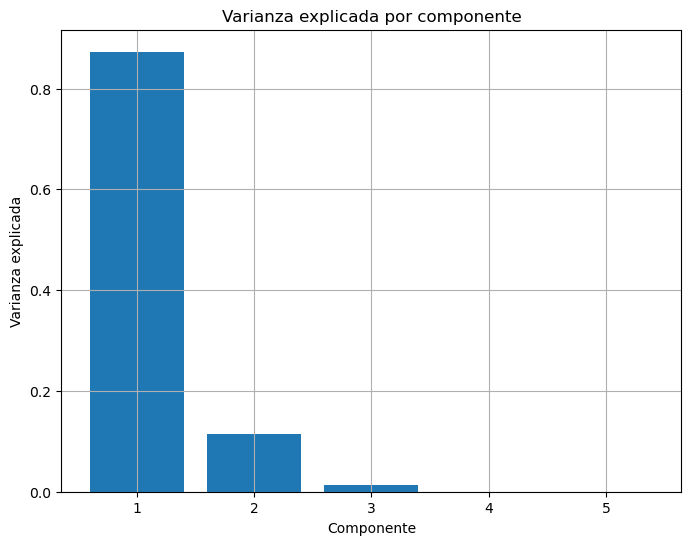

In [106]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Componente')
plt.ylabel('Varianza explicada')
plt.title('Varianza explicada por componente')
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">

Se puede observar, que en el grafico de varianza individual la primera componente explica el 87% de la varianza observada en los datos y la segunda el 11%. Mientras que las restantes componentes alcanzan un 1.2% de varianza explicada.
</div>

### Gráfico de codo

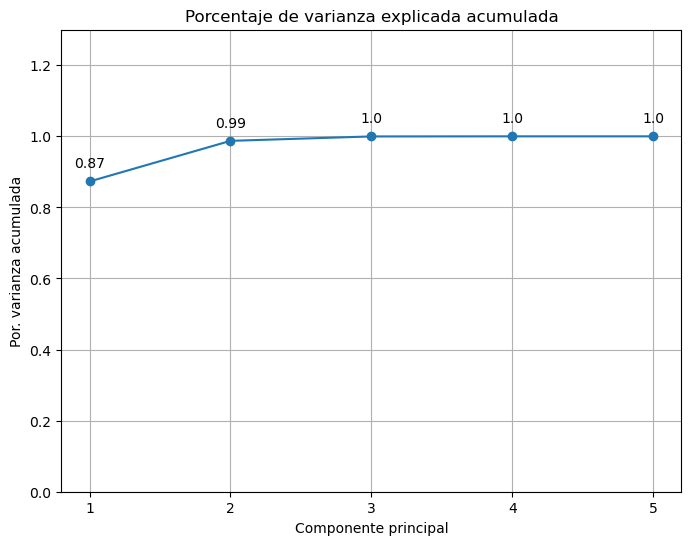

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(
    np.arange(len(colpca)) + 1,
    np.cumsum(pca.explained_variance_ratio_),
    marker = 'o'
)

for x, y in zip(np.arange(len(colpca)) + 1, np.cumsum(pca.explained_variance_ratio_)):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_ylim(0, 1.3)
ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')
plt.grid(True);

<div class="alert alert-block alert-info">
En el grafico de codo. Las dos primera componentes explican sobre el 98% de los datos. Aunque solo usando la primera componente ya se tiene el 87% explicado
    
</div>